In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import pickle
from sklearn.feature_selection import f_regression, SelectKBest
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from scipy.stats import normaltest


## DATA

In [70]:
df = pd.read_csv('for_model.csv')

In [71]:
# 篩選某個年份後
dfyear=df[df['year']>2010]

In [93]:
df['budget_transfer'].describe()


count    9396.000000
mean       16.377613
std         2.345921
min         0.000000
25%        15.717618
50%        16.934257
75%        17.719501
max        20.018046
Name: budget_transfer, dtype: float64

In [88]:
# 檢查是否符合常態分布 預算跟票房皆符合 但圖不像，還是右偏型態
def plot_histogram(column):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(column, bins=50)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1e6) if x >= 1e6 else int(x)))
    plt.title('Histogram of My Column')
    plt.xlabel('budget_transfer')
    plt.ylabel('Frequency')
    plt.show()

# plot_histogram(df['budget_transfer'])

In [82]:
# 使用 normaltest() 函數檢驗該欄位是否符合常態分佈
stat, p = normaltest(df['budget_transfer'])
if p < 0.05:
    print('不符合常態')
else:
    print('是常態')


是常態


In [78]:
# LOG轉換
df['budget_transfer'] = np.log(df['budget_transfer'])
df['revenue_transfer'] = np.log(df['revenue_transfer'])

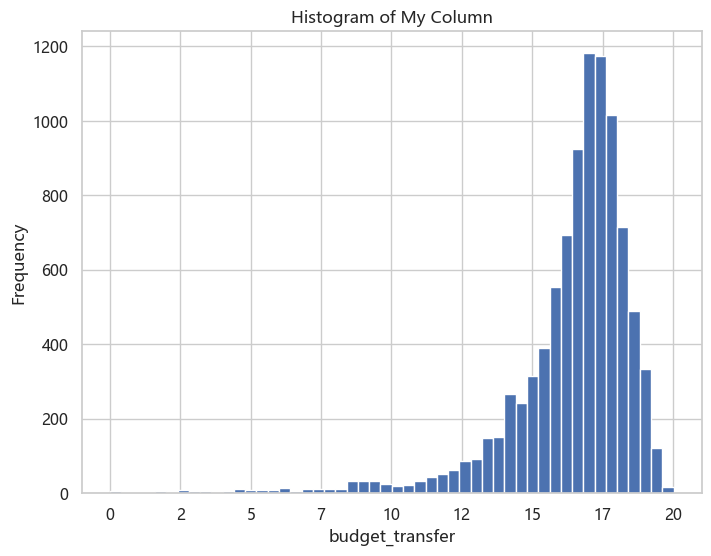

In [91]:
plot_histogram(df['budget_transfer'])

In [100]:
# 剃除離群值
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series > lower_bound) & (series < upper_bound)]
df['budget_transfer']=remove_outliers(df['budget_transfer'])

In [23]:
dfyear.columns

Index(['movie_id', 'imdb_id', 'title', 'en_title', 'budget', 'revenue',
       'release_date', 'avg_rating', 'vote_count', 'casts', 'genres',
       'production_companies', 'adult', 'budget_transfer', 'revenue_transfer',
       'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'actor6', 'year',
       'actor1_count', 'actor2_count', 'actor3_count', 'actor4_count',
       'actor5_count', 'actor6_count', 'sequal', 'year_gap', 'reunion_holiday',
       'non_reunion_holiday', 'decade', 'award_num', 'company_num',
       'genres_num', 'director', 'directing_win_count',
       'production_companies_freq', 'genres_freq', 'director_freq',
       'release_weekday', 'release_month'],
      dtype='object')

In [101]:
X = dfyear[['budget_transfer','actor1_count','actor2_count','actor3_count','actor4_count','actor5_count','actor6_count','sequal','year_gap','reunion_holiday','non_reunion_holiday','decade','award_num','company_num','genres_num','directing_win_count','production_companies_freq','genres_freq','director_freq','release_weekday','release_month']]
y = dfyear['revenue_transfer']

In [54]:
# 為了圖表可以顯示中文的設定
# 設置字體為微軟雅黑
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 



## 多模型比較

LinearRegression R2 score: 0.6688742380403216
XGBoost R2 score: 0.7064416101399285
DecisionTree R2 score: 0.3991501902302613


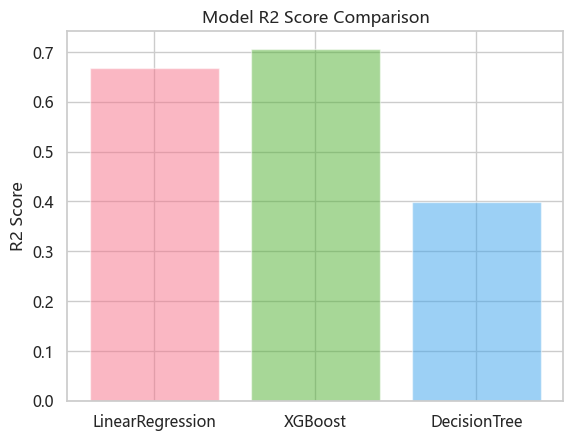

In [102]:
def train_and_evaluate_models(X, y, random_state=48, scaler=StandardScaler()):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    # Standardize data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LinearRegression': LinearRegression(),
        'XGBoost': xgb.XGBRegressor(max_depth=8, n_estimators=2000, learning_rate=0.008),
        # 'SVM': SVR(),
        'DecisionTree': DecisionTreeRegressor()
    }

    # Train the models, make predictions and evaluate using R2 score
    r2_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        r2_scores[model_name] = r2_score(y_test, preds)
        print(f'{model_name} R2 score: {r2_scores[model_name]}')

    # 為每個模型生成顏色
    colors = sns.color_palette("husl", len(models))

    # Visualize R2 scores using a bar chart
    fig, ax = plt.subplots()
    model_names = list(r2_scores.keys())
    r2_values = list(r2_scores.values())
    y_pos = np.arange(len(model_names))
    ax.bar(y_pos, r2_values, align='center', alpha=0.5, color=colors)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('R2 Score')
    ax.set_title('Model R2 Score Comparison')
    plt.show()
train_and_evaluate_models(X, y, random_state=1)

## 挑選特徵

#### LASSO

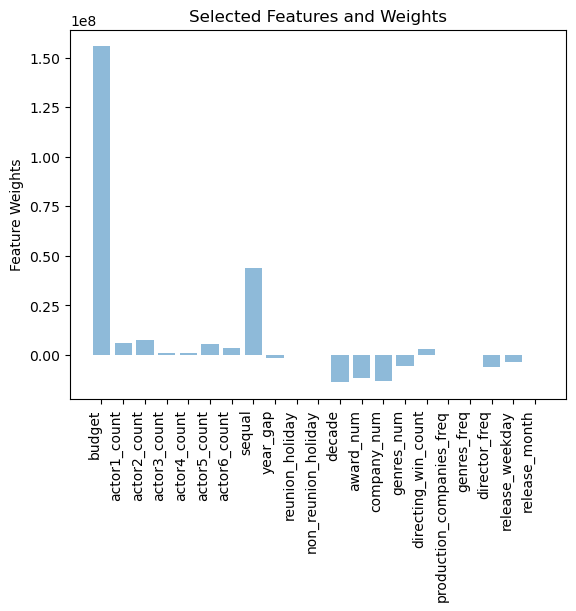

(Index(['budget', 'actor1_count', 'actor2_count', 'actor3_count',
        'actor4_count', 'actor5_count', 'actor6_count', 'sequal', 'year_gap',
        'reunion_holiday', 'non_reunion_holiday', 'decade', 'award_num',
        'company_num', 'genres_num', 'directing_win_count',
        'production_companies_freq', 'genres_freq', 'director_freq',
        'release_weekday', 'release_month'],
       dtype='object'),
 array([ 1.55620961e+08,  6.16708119e+06,  7.65377399e+06,  8.26600331e+05,
         9.47249811e+05,  5.58317635e+06,  3.54784456e+06,  4.39991817e+07,
        -1.50587045e+06,  1.97013587e+05, -1.67980112e+04, -1.38292336e+07,
        -1.17494167e+07, -1.29323298e+07, -5.41213898e+06,  3.17100010e+06,
        -1.23639353e+05, -2.19014129e+05, -6.06471051e+06, -3.27499332e+06,
         7.13723028e+04]))

In [46]:
def select_features_with_lasso_and_visualize(X, y, alpha=0.1):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    nonzero_indices = np.nonzero(lasso.coef_)[0]
    selected_features = X.columns[nonzero_indices]
    feature_weights = lasso.coef_[nonzero_indices]

    # Visualize selected features and their weights using a bar chart
    fig, ax = plt.subplots()
    y_pos = np.arange(len(selected_features))
    ax.bar(y_pos, feature_weights, align='center', alpha=0.5)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(selected_features, rotation=90, ha='right')
    ax.set_ylabel('Feature Weights')
    ax.set_title('Selected Features and Weights')
    plt.show()

    return selected_features, feature_weights
select_features_with_lasso_and_visualize(X, y)

### 隨機森林

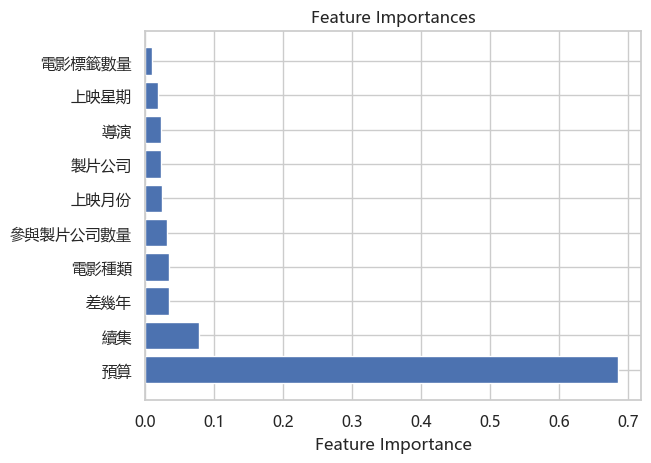

,budget_transfer,actor1_count,actor2_count,actor3_count,actor4_count,actor5_count,actor6_count,sequal,year_gap,reunion_holiday,...,decade,award_num,company_num,genres_num,directing_win_count,production_companies_freq,genres_freq,director_freq,release_weekday,release_month
0,540.0,0,0,0,0,0,0,0.0,2.0,0.0,...,11.0,0.0,1.0,3.0,0.0,0.000106,0.005955,0.000106,7.0,10.0
1,570.0,0,0,0,0,0,0,0.0,4.0,0.0,...,10.0,0.0,0.0,2.0,0.0,0.037431,0.001595,0.000106,1.0,12.0
2,565.0,0,0,0,0,0,0,0.0,3.0,0.0,...,10.0,0.0,0.0,3.0,0.0,0.037431,0.002552,0.000106,7.0,6.0
3,108.0,0,0,0,0,0,0,0.0,2.0,0.0,...,11.0,0.0,1.0,2.0,0.0,0.000106,0.001063,0.000106,2.0,5.0
4,20.0,0,0,0,0,0,0,0.0,1.0,0.0,...,11.0,0.0,0.0,3.0,0.0,0.037431,0.000957,0.000106,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9399,189000.0,0,0,0,0,0,0,0.0,2.0,0.0,...,11.0,0.0,1.0,2.0,0.0,0.000106,0.000425,0.000106,5.0,6.0
9400,2484000.0,0,0,0,0,0,0,0.0,2.0,0.0,...,11.0,0.0,1.0,2.0,0.0,0.000106,0.004147,0.000106,7.0,5.0
9401,16950000.0,0,0,0,0,0,0,0.0,3.0,0.0,...,10.0,0.0,1.0,2.0,0.0,0.000106,0.005317,0.000425,5.0,10.0
9402,13560000.0,0,0,0,0,0,0,0.0,3.0,0.0,...,10.0,0.0,2.0,3.0,0.0,0.000106,0.000106,0.000106,4.0,7.0


In [103]:
def train_rf_and_get_importances_with_plot(X, y, feature_names=None, problem_type="regression", top_n=10, threshold=None):
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    if problem_type == "classification":
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf_model.fit(X, y)
    importances = rf_model.feature_importances_

    fig, ax = plt.subplots()
    num_features = len(importances)
    if top_n > num_features:
        top_n = num_features
    indices = np.argsort(importances)[-top_n:][::-1]
    ax.barh(range(top_n), importances[indices], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(feature_names[i] for i in indices)
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importances')
    plt.show()

    if threshold:
        sfm = SelectFromModel(rf_model, threshold=threshold)
        sfm.fit(X, y)
        X_important = sfm.transform(X)
        print(f"篩選後的特徵維度： {X_important.shape[1]}")
        return X_important
    else:
        return X
# 定義特徵名稱
feature_names=['預算','演員1得獎','演員2得獎','演員3得獎','演員4得獎','演員5得獎','演員6得獎','續集','差幾年','團聚假日','非團聚假日','每十年','演員總得獎次數','參與製片公司數量','電影標籤數量','導演得獎次數','製片公司','電影種類','導演','上映星期','上映月份','票房']
train_rf_and_get_importances_with_plot(X,y,problem_type="regression",feature_names=feature_names)

### 相關係數 熱力圖

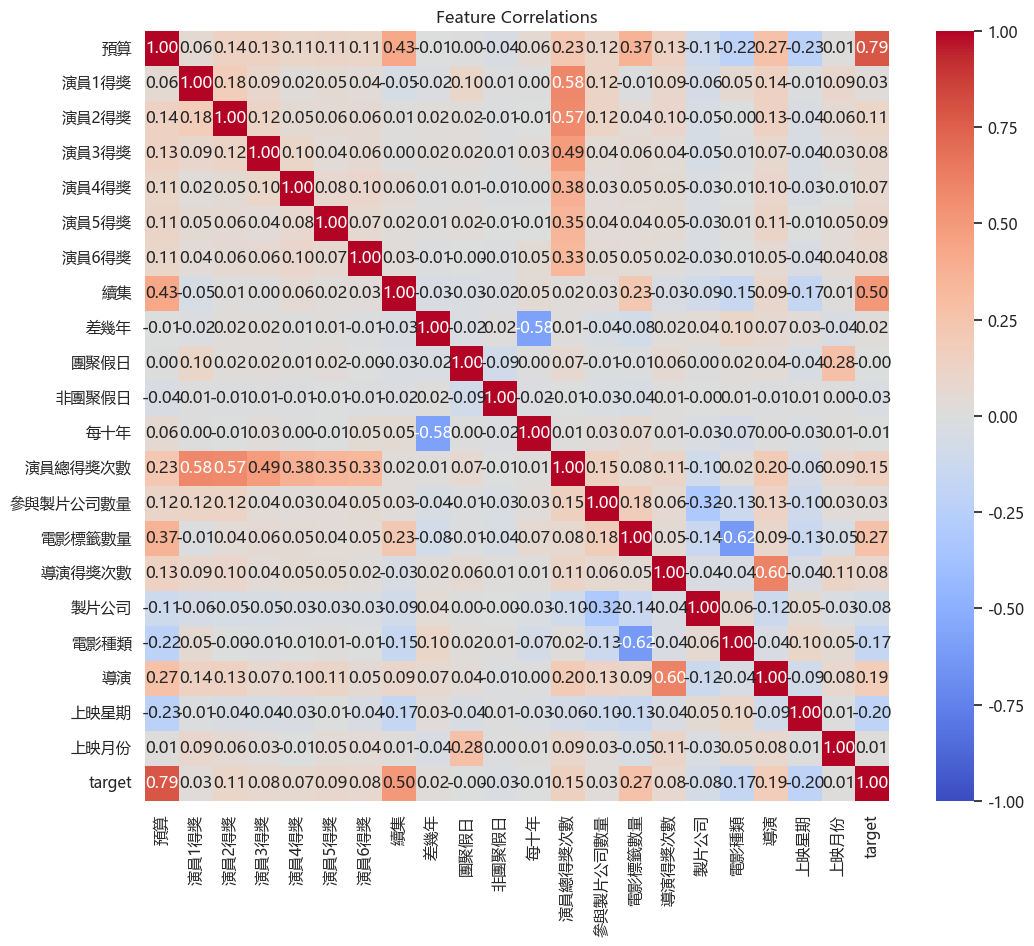

與目標變量的相關係數：
預算          0.788834
續集          0.502829
電影標籤數量      0.271697
上映星期        0.203142
導演          0.185802
電影種類        0.168374
演員總得獎次數     0.152859
演員2得獎       0.106302
演員5得獎       0.091577
導演得獎次數      0.084403
演員6得獎       0.078451
演員3得獎       0.076837
製片公司        0.075665
演員4得獎       0.074465
演員1得獎       0.029439
非團聚假日       0.025328
參與製片公司數量    0.025209
差幾年         0.015636
上映月份        0.013502
每十年         0.005179
團聚假日        0.000240
Name: target, dtype: float64

根據相關係數選擇的特徵：
Index(['預算', '續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數', '演員2得獎'], dtype='object')


Index(['預算', '續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數', '演員2得獎'], dtype='object')

In [106]:
def select_features_by_correlation(X, y, feature_names=None, threshold=0.1, plot_heatmap=True):
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    # 將 y 添加到 DataFrame 中
    X_with_target = X.copy()
    X_with_target['target'] = y
    X_with_target.columns = feature_names + ['target']

    # 計算相關係數
    correlations = X_with_target.corr()

    # 繪製熱力圖
    if plot_heatmap:
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title("Feature Correlations")
        plt.show()

    # 計算與目標變量的相關係數並排序
    target_correlations = correlations['target'].drop('target', axis=0)
    target_correlations_sorted = target_correlations.abs().sort_values(ascending=False)

    print("與目標變量的相關係數：")
    print(target_correlations_sorted)

    # 挑選與目標變量相關係數絕對值大於某個閾值的特徵
    selected_features = target_correlations_sorted[target_correlations_sorted.abs() > threshold].index
    print("\n根據相關係數選擇的特徵：")
    print(selected_features)

    return selected_features

# 定義自己的特徵名稱
feature_names=['預算','演員1得獎','演員2得獎','演員3得獎','演員4得獎','演員5得獎','演員6得獎','續集','差幾年','團聚假日','非團聚假日','每十年','演員總得獎次數','參與製片公司數量','電影標籤數量','導演得獎次數','製片公司','電影種類','導演','上映星期','上映月份']
select_features_by_correlation(X, y, feature_names, threshold=0.1, plot_heatmap=True)


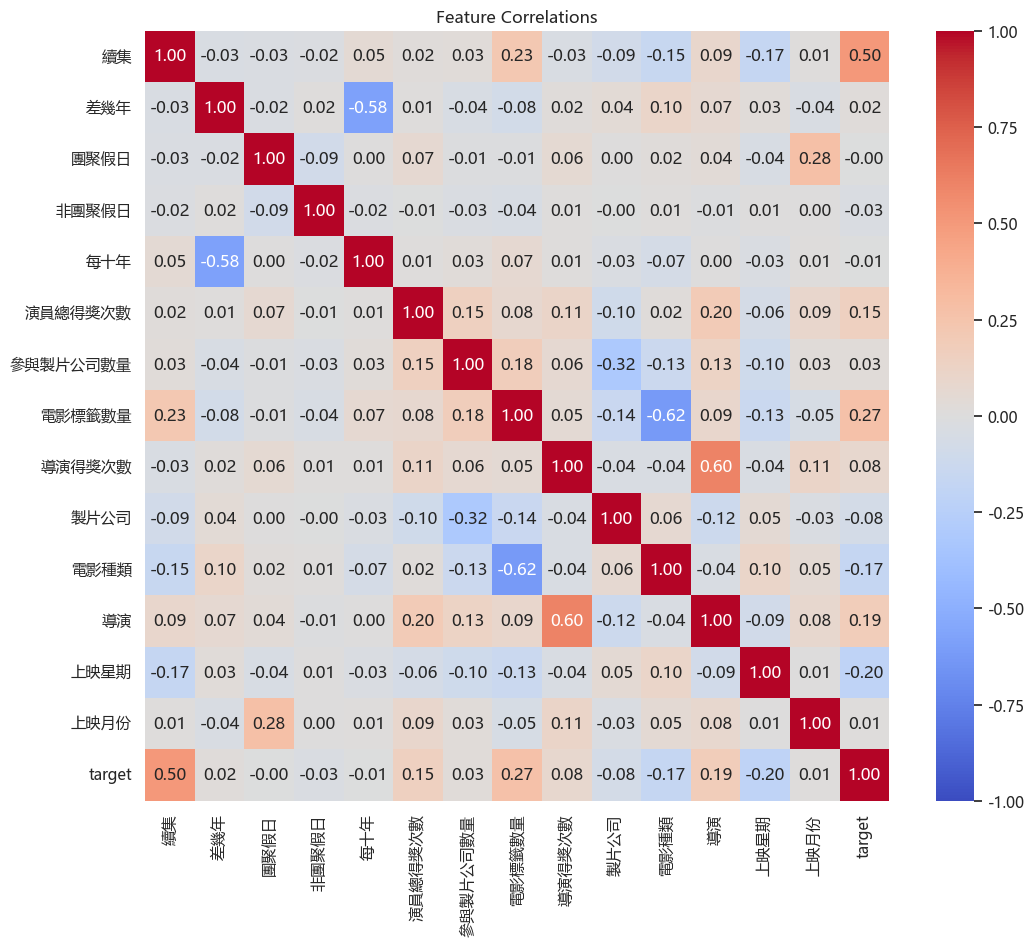

與目標變量的相關係數：
續集          0.502829
電影標籤數量      0.271697
上映星期        0.203142
導演          0.185802
電影種類        0.168374
演員總得獎次數     0.152859
導演得獎次數      0.084403
製片公司        0.075665
非團聚假日       0.025328
參與製片公司數量    0.025209
差幾年         0.015636
上映月份        0.013502
每十年         0.005179
團聚假日        0.000240
Name: target, dtype: float64

根據相關係數選擇的特徵：
Index(['續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')


Index(['續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')

In [112]:
# 刪除與y相關性太高的預算及刪減部分相關性高的特徵欄位後再看一次
X = dfyear[['sequal','year_gap','reunion_holiday','non_reunion_holiday','decade','award_num','company_num','genres_num','directing_win_count','production_companies_freq','genres_freq','director_freq','release_weekday','release_month']]
feature_names=['續集','差幾年','團聚假日','非團聚假日','每十年','演員總得獎次數','參與製片公司數量','電影標籤數量','導演得獎次數','製片公司','電影種類','導演','上映星期','上映月份']
select_features_by_correlation(X, y, feature_names, threshold=0.1, plot_heatmap=True)


## 減少特徵後再次跑模型

In [113]:
# 減少特徵欄位
X = dfyear[['budget_transfer','sequal','award_num','genres_num','production_companies_freq','genres_freq','director_freq','release_weekday','release_month','company_num',]]
y = dfyear['revenue_transfer']

LinearRegression R2 score: 0.6647434588990182
XGBoost R2 score: 0.6968595946675123
DecisionTree R2 score: 0.5511435584301962


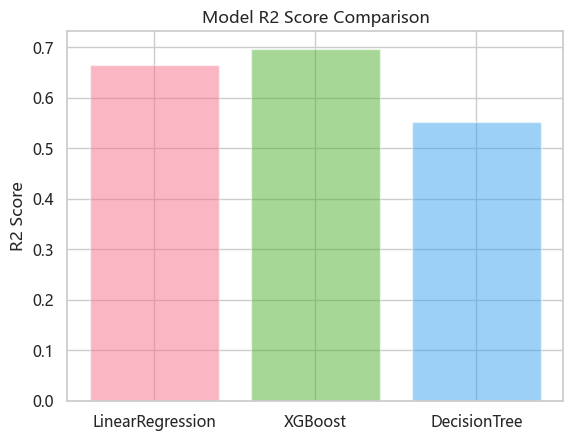

In [115]:
train_and_evaluate_models(X, y,)

## 選定XGBOOST

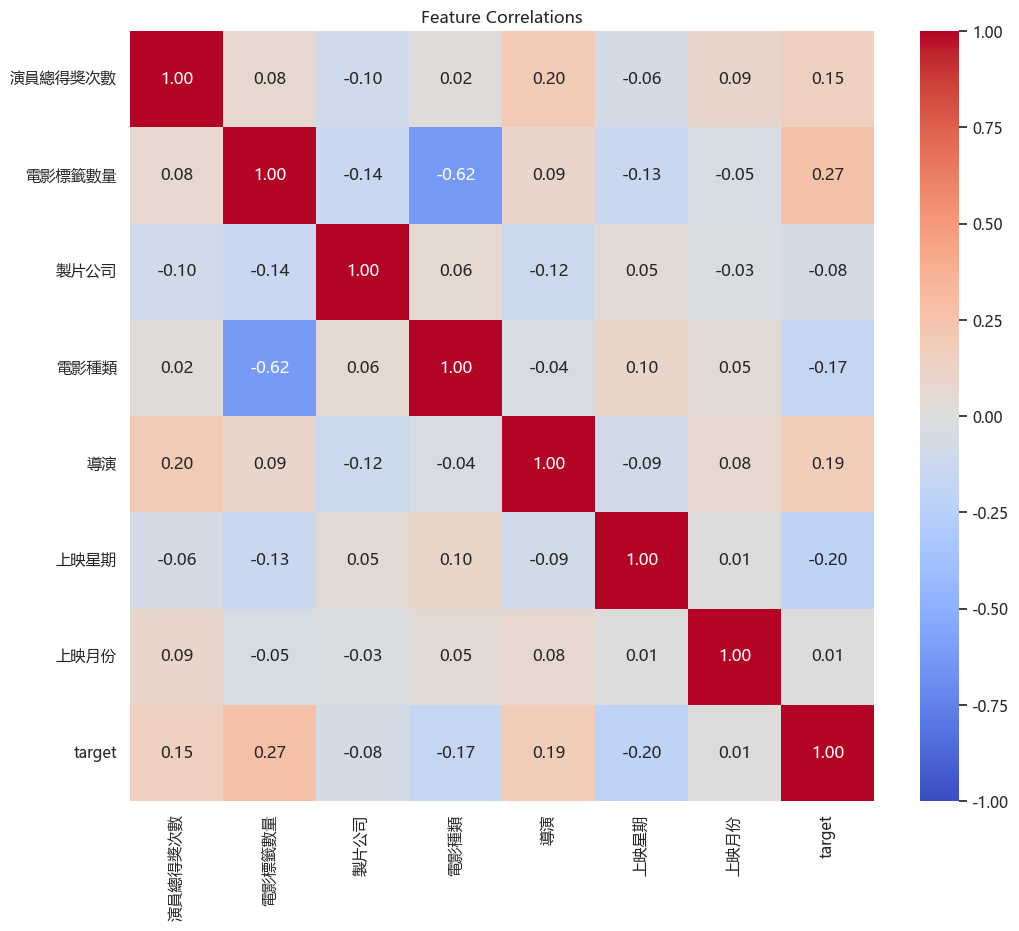

與目標變量的相關係數：
電影標籤數量     0.271697
上映星期       0.203142
導演         0.185802
電影種類       0.168374
演員總得獎次數    0.152859
製片公司       0.075665
上映月份       0.013502
Name: target, dtype: float64

根據相關係數選擇的特徵：
Index(['電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')


Index(['電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')

In [121]:
# 繪製相關係數熱力圖
# 這邊重複挑選特徵，互相比較驗證
feature_names=['演員總得獎次數','電影標籤數量','製片公司','電影種類','導演','上映星期','上映月份']
X = dfyear[['award_num','genres_num','production_companies_freq','genres_freq','director_freq','release_weekday','release_month',]]
y = dfyear['revenue_transfer']
select_features_by_correlation(X, y,feature_names=feature_names)

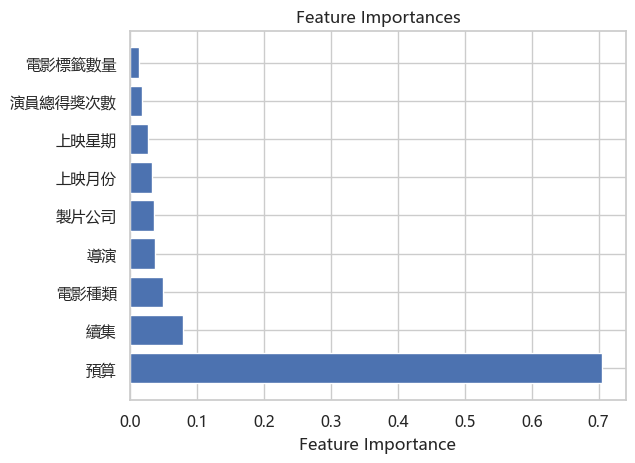

,budget_transfer,sequal,award_num,genres_num,production_companies_freq,genres_freq,director_freq,release_weekday,release_month
0,540.0,0.0,0.0,3.0,0.000106,0.005955,0.000106,7.0,10.0
1,570.0,0.0,0.0,2.0,0.037431,0.001595,0.000106,1.0,12.0
2,565.0,0.0,0.0,3.0,0.037431,0.002552,0.000106,7.0,6.0
3,108.0,0.0,0.0,2.0,0.000106,0.001063,0.000106,2.0,5.0
4,20.0,0.0,0.0,3.0,0.037431,0.000957,0.000106,1.0,10.0
...,...,...,...,...,...,...,...,...,...
9399,189000.0,0.0,0.0,2.0,0.000106,0.000425,0.000106,5.0,6.0
9400,2484000.0,0.0,0.0,2.0,0.000106,0.004147,0.000106,7.0,5.0
9401,16950000.0,0.0,0.0,2.0,0.000106,0.005317,0.000425,5.0,10.0
9402,13560000.0,0.0,0.0,3.0,0.000106,0.000106,0.000106,4.0,7.0


In [117]:
# 隨機森林篩選特徵
train_rf_and_get_importances_with_plot(X,y,problem_type="regression",feature_names=feature_names)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=48)
#標準化
scaler = StandardScaler()
# 對訓練集進行標準化
X_train = scaler.fit_transform(X_train)
# 對測試集進行標準化
X_test = scaler.transform(X_test)
#將資料分成三份 調整參數
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### XGBoost

Best R2 score: 0.6954382511993682


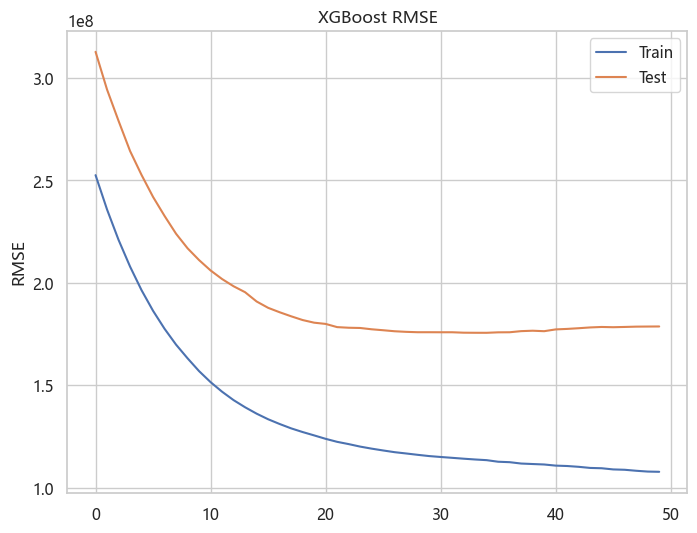

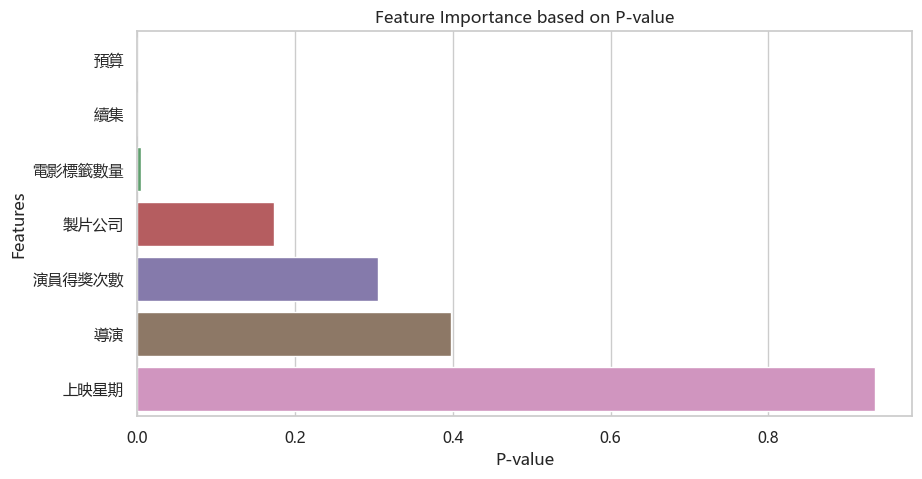

In [157]:
def xgb_gridsearch_train(X_train, y_train, X_val, y_val, feature_names=None, param_grid=None, eval_metric='mae', plot_learning_curve=True, plot_feature_importance=True):

    if not param_grid:
        param_grid = {
            'max_depth': [3, 4, 5, 6, 7],
            'n_estimators': [10, 50, 100, 1000],
            'learning_rate': [0.001, 0.01, 0.1],
            'random_state': [42],
            'eval_metric': [eval_metric]
        }

    xgb_model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    xgb_best_model = xgb.XGBRegressor(**best_params, early_stopping_rounds=100)
    xgb_best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)
    best_r2 = grid_search.best_score_
    print(f'Best R2 score: {best_r2}')
    
    if plot_learning_curve:
        plt.figure(figsize=(8, 6))
        train_results = xgb_best_model.evals_result()
        epochs = len(train_results['validation_0'][eval_metric])
        x_axis = range(0, epochs)
        plt.plot(x_axis, train_results['validation_0'][eval_metric], label='Train')
        plt.plot(x_axis, train_results['validation_1'][eval_metric], label='Test')
        plt.legend()
        plt.ylabel(eval_metric.upper())
        plt.title(f'XGBoost {eval_metric.upper()}')
        plt.show()

    if feature_names is not None and plot_feature_importance:
        X2 = sm.add_constant(X_train)
        ols_model = sm.OLS(y_train, X2)
        ols_results = ols_model.fit()
        p_values = ols_results.pvalues[1:]
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'P_value': p_values})
        feature_importance_df_sorted = feature_importance_df.sort_values('P_value')

        plt.figure(figsize=(10, 5))
        sns.barplot(x='P_value', y='Feature', data=feature_importance_df_sorted)
        plt.xlabel('P-value')
        plt.ylabel('Features')
        plt.title('Feature Importance based on P-value')
        plt.show()

        return xgb_best_model, feature_importance_df_sorted, best_r2

    else:
        return xgb_best_model, None, best_r2





xgb_best_model, feature_importance_df_sorted, best_r2=xgb_gridsearch_train(X_train, y_train, X_val, y_val, feature_names,eval_metric='mae' )


### 選擇最後要的特徵 ->調整超參數 ->訓練出最後模型

In [149]:
# 減少特徵欄位
feature_names=['預算','續集','電影標籤數量','製片公司','演員得獎次數','導演','上映星期']
X = dfyear[['budget_transfer','sequal','genres_num','production_companies_freq','award_num','director_freq','release_weekday']]
y = dfyear['revenue_transfer']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=48)
#標準化
scaler = StandardScaler()
# 對訓練集進行標準化
X_train = scaler.fit_transform(X_train)
# 對測試集進行標準化
X_test = scaler.transform(X_test)
#將資料分成三份 調整參數
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Best R2 score: 0.6928107943441821


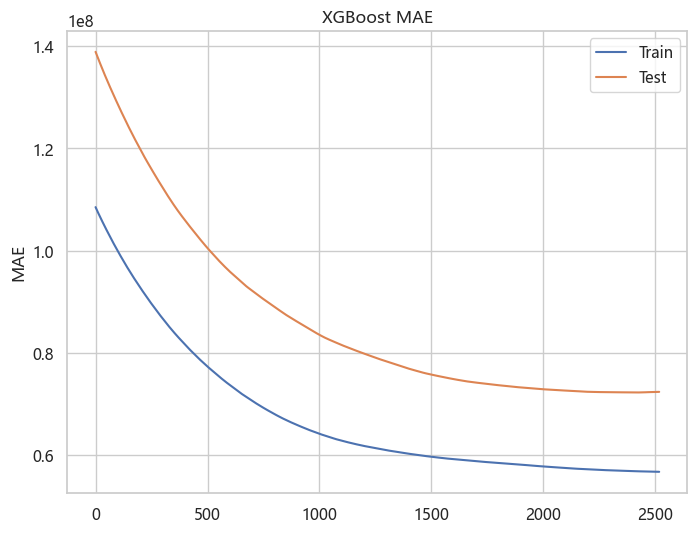

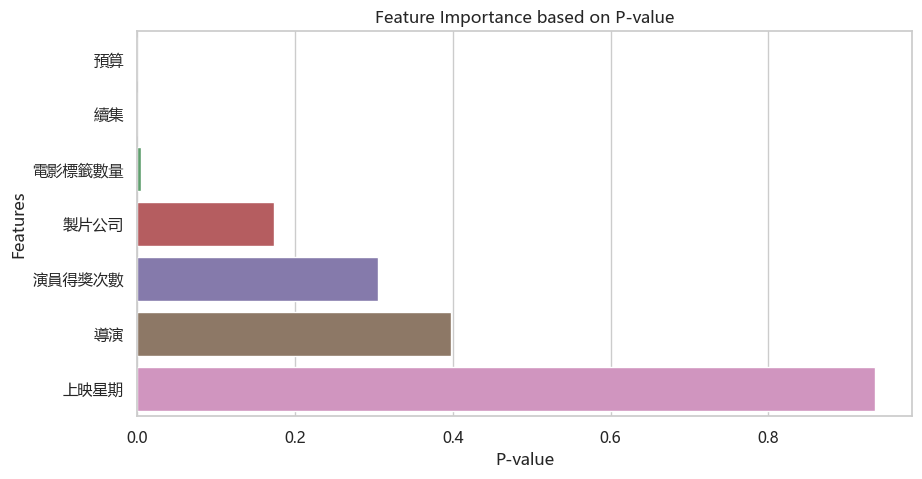

In [151]:
# 調整超參數，訓練最終模型
param_grid = {
            'max_depth': [3, 4, 5, 6, 7],
            'n_estimators': list(range(1, 20001)),
            'learning_rate': [0.001, 0.01, 0.1],
            'random_state': [42],
        }
xgb_best_model, feature_importance_df_sorted, best_r2=xgb_gridsearch_train(X_train, y_train, X_val, y_val, feature_names=feature_names,eval_metric='mae',param_grid=param_grid )

In [155]:
range(100)

range

## 將最終訓練的模型存檔 供Flask使用

In [57]:
# 將頻率編碼對應的欄位數字存成字典
def save_freq_dict(df, feature_name):
    freq_dict = df.set_index(feature_name)[f"{feature_name}_freq"].to_dict()
    with open(f"{feature_name}_freq_mapping.pkl", "wb") as file:
        pickle.dump(freq_dict, file)

# 預計有哪些欄位需要對應存檔
save_freq_dict(df, "genres")
save_freq_dict(df, "production_companies")
save_freq_dict(df, "director")


In [58]:
# 模型存檔
with open("xgb_best_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
# 標準化數據存檔
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)